In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *
from torchcfm.sample_parameters import GaussianPairContainer

savedir = "models/prior-invariance"
os.makedirs(savedir, exist_ok=True)

In [2]:
gaussian_pair = GaussianPairContainer(
    prior_mu=torch.distributions.Uniform(0.0, 10),
    prior_sigma=torch.distributions.Uniform(1.0, 1.01),
    ll_mu=3.0,
    ll_sigma=1.0,
)

In [3]:
sigma = 0.1
dim = 1
batch_size = 256

model = MLP(dim=dim+gaussian_pair.num_params, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(1000):
    optimizer.zero_grad()

    x0, x1 = gaussian_pair.sample_pair((batch_size, 1))

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    # if (k + 1) % 100 == 0:
    if (k + 1) in (10, 300, 1000):
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )

        if (showresults := False):
            with torch.no_grad():
                samples = gaussian_pair.sample_prior(
                    (500, 1),
                    mu_fixed=0.0, sigma_fixed=1.0 
                    )
                print(samples.shape)
                traj = node.trajectory(
                    samples,
                    t_span=torch.linspace(0, 1, 100),
                )[:, :, :1]
                # traj.shape = [100, 1024, dim]
                plot_trajectories_1d(
                    traj.cpu().numpy(),
                )

torch.save(model, f"{savedir}/cfm_params_v1.pt")

10: loss 0.943 time 0.03
300: loss 0.416 time 0.79
1000: loss 0.389 time 2.07


## Invariance

Now, let's test this:

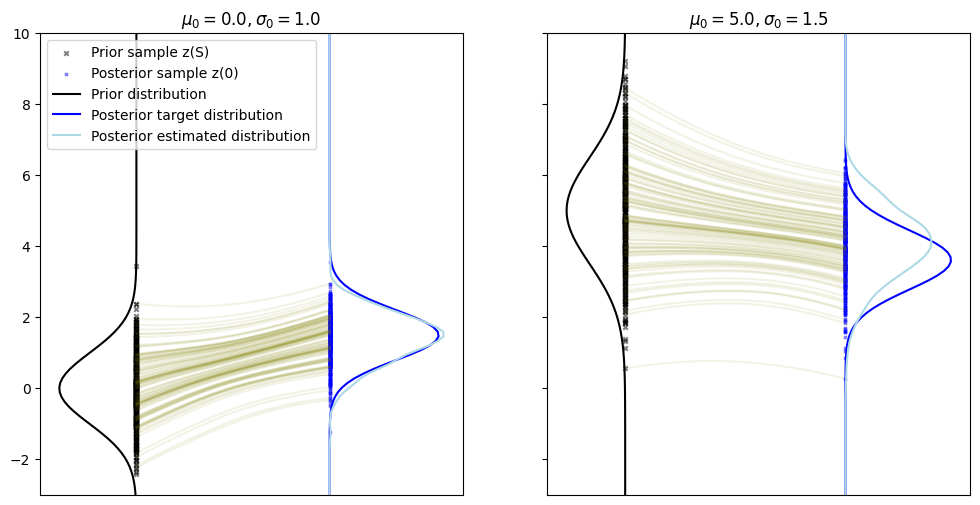

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
mus = (0.0, 5.0)
sigmas = (1.0, 1.5)

model = torch.load(f"{savedir}/cfm_params_v1.pt")

for (m, s, ax) in zip(mus, sigmas, axs):

    mu_fixed = m
    sigma_fixed = s

    node = NeuralODE(
        torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
    )

    with torch.no_grad():
        ax.set_title(f"$\mu_0={mu_fixed}, \sigma_0={sigma_fixed}$")
        samples = gaussian_pair.sample_prior(
            (500, 1),
            mu_fixed, sigma_fixed
        )
        traj = node.trajectory(
            samples,
            t_span=torch.linspace(0, 1, 100),
        )
        # traj.shape = [100, 1024, dim]
        prior, posterior = gaussian_pair.fixed_distributions(
            mu_fixed, torch.tensor(sigma_fixed)
        )
        _ = plot_trajectories_1d(
            traj.cpu().numpy(),
            prior, posterior,
            fig=fig, ax=ax
        )
        ax.set_ylim([-3, 10])
    
axs[0].legend()
fig.savefig(f"{savedir}/prior_amortized.pdf")